In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib as plt
import healpy as hp
import numpy as np

from deepsphere import healpy_layers as hp_layers
from deepsphere import HealpyGCNN

from source.base_model import HealpyModel
from source import data, plotting

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

### Graph Convolutional Neural Networks

This notebook gives an introduction to the graph convolutional neural networks (GCNN) used in the paper. Note that we illustrate the ussage with a very small toy model, as the networks and the dataset presented in the paper are too large to run on the average laptop. 

We start with the generation of a small dataset using the fiducial parameters. The generation of the data used in the paper is described in the notebook `data_generation.ipynb`, here, we do not use the survey settings described in the paper. We will use a setting that is much more managable but does not correspond to a realistic setting.

In [3]:
# load the fiducial data including the spectra
fiducial_data = np.load("../data/fiducial_data.npz")

# select the spectra for the 2D model
spectra = fiducial_data["spectra"][[0,1,2,9,10]]
# select deltas for the 2D model (used later)
deltas = fiducial_data["deltas"].astype(np.float32)[[0,4]]

# define a survey mask
nside = 16
npix = hp.nside2npix(nside)
data_mask = data_mask_pad = np.ones(npix, dtype=np.bool)

# generate data
dset = []
size_dset = 512
for seed in tqdm(fiducial_data["numpy_seeds"][:size_dset]):
    dset.append(data.create_GRF_samples(spectra=spectra, 
                                        data_mask=data_mask, 
                                        data_mask_pad=data_mask_pad, 
                                        seed=seed,
                                        lmax=3*nside + 1))

100%|██████████| 512/512 [00:16<00:00, 30.69it/s]


We will plot a single map to see the difference with respect to the dataset presented in the paper.

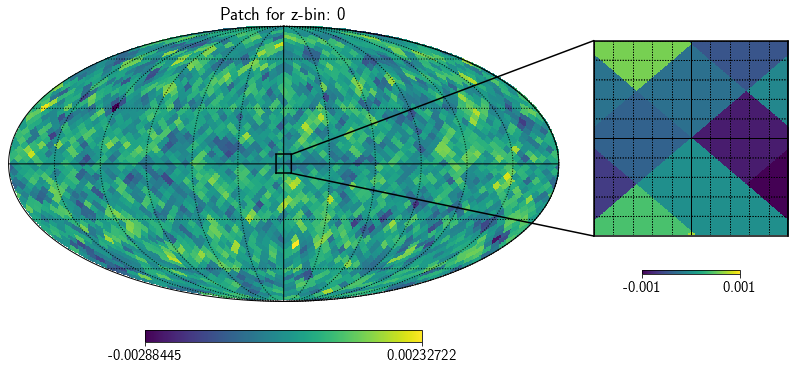

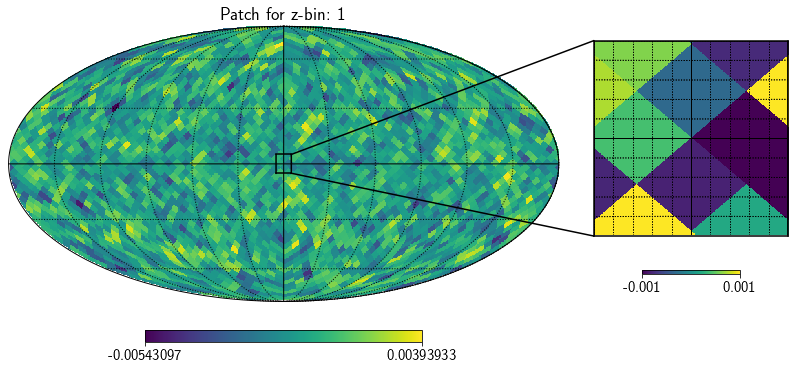

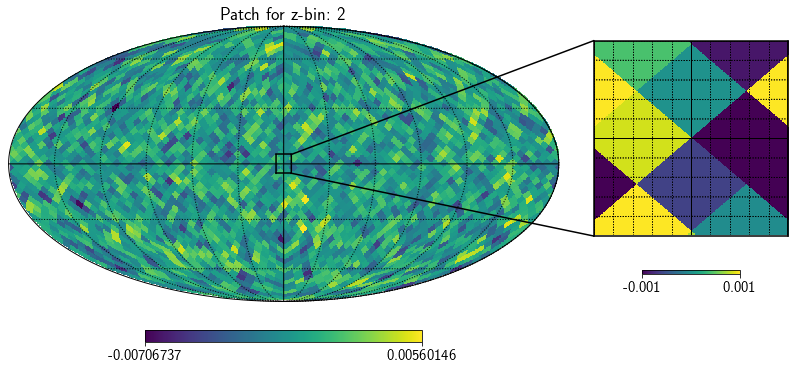

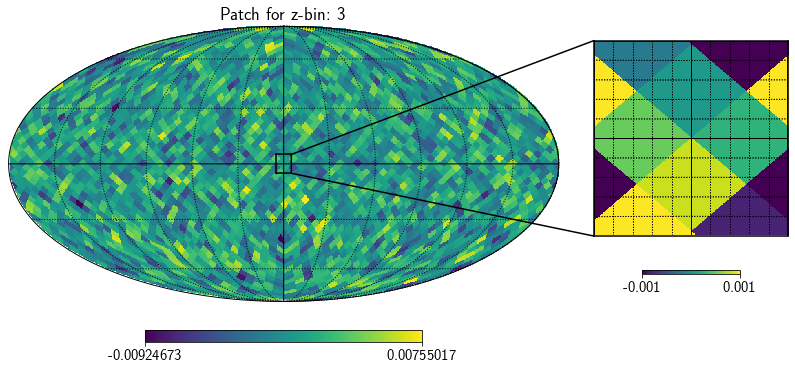

In [4]:
plotting.plot_patches_nice(dset[0][0].T, data_mask_pad, clim=[-0.001, 0.001])

To train the network according to the loss described by equation (7) in the paper, we need to order the dataset in a specific way. Assuming that the total batch size is $n(2d_\theta + 1)$, the first $n$ maps should be generated with the unperturbed fiducial parameter, this should be followed by the __negative__ perturbation of the first parameter, followed by the __positive__ perturbation of the first parameter, followed by the remaining perturbations alternating between positive and negative. We will generate a `tensorflow` dataset that can be consumed by the network.

In [5]:
n_batch = 16
tf_dset = tf.data.Dataset.from_tensor_slices(np.array(dset).astype(np.float32))
tf_dset = tf_dset.batch(n_batch)
tf_dset = tf_dset.map(lambda x: tf.reshape(tf.transpose(x, perm=[1,0,2,3]), [-1, npix, 4]))

We proceed with building a GCNN using `deepsphere`. For this we need to define the relevant pixels (indices of the pixels used in the observed region) and a list of layers.

In [6]:
# the relevant pixel
relevant_pixels = np.arange(npix)

# a list of layers (like the Sequential model)
layers = [hp_layers.HealpyPseudoConv(p=1, Fout=8, activation=tf.nn.relu),
          hp_layers.HealpyPseudoConv(p=1, Fout=16, activation=tf.nn.relu),
          hp_layers.HealpyChebyshev(K=5, Fout=32, activation=tf.nn.relu),
          hp_layers.HealpyChebyshev(K=5, Fout=32, activation=tf.nn.relu),
          hp_layers.HealpyChebyshev(K=5, Fout=32, activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(2)]

# define the network, build and print a summary
network = HealpyGCNN(nside=nside, indices=relevant_pixels, layers=layers)
network.build(input_shape=(None, npix, 4))
network.summary(110)

Detected a reduction factor of 4.0, the input with nside 16 will be transformed to 4 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
healpy_pseudo_conv (HealpyPseudoConv)            (None, 768, 8)                              136              
______________________________________________________________________________________________________________
healpy_pseudo_conv_1 (HealpyPseudoConv)          (None, 192, 16)                             528              
______________________________________________________________________________________________________________
chebyshev (Chebyshev)                            (None, 192, 32)                             2560             
________________________

Now, we wrap the network into our model, making the training very simple. The model can take care of a lot of things, like writing tensorboard summaries, writing checkpoints and handling distributed training using `horovod`. We will only go thought the very basics.

In [7]:
model = HealpyModel(network)

We set up the loss function such that we can start with the training.

In [8]:
model.setup_delta_loss_step(batch_size=n_batch, 
                            off_sets=deltas, 
                            n_channels=4, 
                            jac_weight=10.0,
                            clip_by_global_norm=5.0,
                            return_loss=True)

We wrap the training step into another function to add the observational noise. Note that we use the same noise for all perturbations.

In [9]:
n_gal_per_bin = 10
n_params = 2
tf_std_noise = tf.constant(0.3/(hp.nside2pixarea(nside=nside, 
                                                 degrees=True)*60.0**2*n_gal_per_bin)**0.5,
                           dtype=tf.float32)
@tf.function
def noisy_train_step(tensor_in):
    noise = tf.random.normal(shape=(n_batch, npix, 4), stddev=tf_std_noise)
    noise = tf.concat([noise for i in range(2*n_params + 1)], axis=0)
    # add to input
    tensor_in = tf.add(tensor_in, noise)
    # perform normal train_step
    loss_val = model.delta_train_step(tensor_in)
    return loss_val

We do a classic training loop.

In [10]:
n_epoch = 50
for epoch in range(n_epoch):
    print(f"Starting with epoch {epoch}...", flush=True)
    with tqdm(tf_dset, total=size_dset//n_batch) as pbar:
        for batch in pbar:
            loss = noisy_train_step(batch)
            pbar.set_postfix(loss_val=loss.numpy(), refresh=False)

Starting with epoch 0...


100%|██████████| 32/32 [00:05<00:00,  5.77it/s, loss_val=1.2]  

Starting with epoch 1...



100%|██████████| 32/32 [00:02<00:00, 14.66it/s, loss_val=-4.75]

Starting with epoch 2...



100%|██████████| 32/32 [00:02<00:00, 14.71it/s, loss_val=-7.97]

Starting with epoch 3...



100%|██████████| 32/32 [00:02<00:00, 14.95it/s, loss_val=-9.58]

Starting with epoch 4...



100%|██████████| 32/32 [00:02<00:00, 14.67it/s, loss_val=-9.56]

Starting with epoch 5...



100%|██████████| 32/32 [00:02<00:00, 14.80it/s, loss_val=-9.7] 

Starting with epoch 6...



100%|██████████| 32/32 [00:02<00:00, 14.75it/s, loss_val=-9.48]

Starting with epoch 7...



100%|██████████| 32/32 [00:02<00:00, 14.53it/s, loss_val=-10.1]

Starting with epoch 8...



100%|██████████| 32/32 [00:02<00:00, 14.66it/s, loss_val=-10.4]

Starting with epoch 9...



100%|██████████| 32/32 [00:02<00:00, 14.64it/s, loss_val=-10.1]

Starting with epoch 10...



100%|██████████| 32/32 [00:02<00:00, 14.59it/s, loss_val=-10.2]

Starting with epoch 11...



100%|██████████| 32/32 [00:02<00:00, 14.51it/s, loss_val=-11]  

Starting with epoch 12...



100%|██████████| 32/32 [00:02<00:00, 14.63it/s, loss_val=-10.7]

Starting with epoch 13...



100%|██████████| 32/32 [00:02<00:00, 14.72it/s, loss_val=-10.9]

Starting with epoch 14...



100%|██████████| 32/32 [00:02<00:00, 14.64it/s, loss_val=-11.4]

Starting with epoch 15...



100%|██████████| 32/32 [00:02<00:00, 14.69it/s, loss_val=-11.3]

Starting with epoch 16...



100%|██████████| 32/32 [00:02<00:00, 14.66it/s, loss_val=-10.6]

Starting with epoch 17...



100%|██████████| 32/32 [00:02<00:00, 14.87it/s, loss_val=-11.2]

Starting with epoch 18...



100%|██████████| 32/32 [00:02<00:00, 14.78it/s, loss_val=-11]  

Starting with epoch 19...



100%|██████████| 32/32 [00:02<00:00, 14.67it/s, loss_val=-12.3]

Starting with epoch 20...



100%|██████████| 32/32 [00:02<00:00, 14.98it/s, loss_val=-11.9]

Starting with epoch 21...



100%|██████████| 32/32 [00:02<00:00, 14.54it/s, loss_val=-11.3]

Starting with epoch 22...



100%|██████████| 32/32 [00:02<00:00, 14.84it/s, loss_val=-11.7]

Starting with epoch 23...



100%|██████████| 32/32 [00:02<00:00, 14.80it/s, loss_val=-11.8]

Starting with epoch 24...



100%|██████████| 32/32 [00:02<00:00, 14.96it/s, loss_val=-12]  

Starting with epoch 25...



100%|██████████| 32/32 [00:02<00:00, 14.71it/s, loss_val=-11.1]

Starting with epoch 26...



100%|██████████| 32/32 [00:02<00:00, 14.53it/s, loss_val=-11.4]

Starting with epoch 27...



100%|██████████| 32/32 [00:02<00:00, 14.88it/s, loss_val=-11.6]

Starting with epoch 28...



100%|██████████| 32/32 [00:02<00:00, 14.29it/s, loss_val=-11.1]

Starting with epoch 29...



100%|██████████| 32/32 [00:02<00:00, 14.54it/s, loss_val=-12.6]

Starting with epoch 30...



100%|██████████| 32/32 [00:02<00:00, 14.54it/s, loss_val=-11.6]

Starting with epoch 31...



100%|██████████| 32/32 [00:02<00:00, 14.16it/s, loss_val=-11.8]

Starting with epoch 32...



100%|██████████| 32/32 [00:02<00:00, 14.76it/s, loss_val=-12.2]

Starting with epoch 33...



100%|██████████| 32/32 [00:02<00:00, 14.80it/s, loss_val=-11.8]

Starting with epoch 34...



100%|██████████| 32/32 [00:02<00:00, 14.58it/s, loss_val=-12.1]

Starting with epoch 35...



100%|██████████| 32/32 [00:02<00:00, 14.97it/s, loss_val=-13]  

Starting with epoch 36...



100%|██████████| 32/32 [00:02<00:00, 14.69it/s, loss_val=-12.3]

Starting with epoch 37...



100%|██████████| 32/32 [00:02<00:00, 14.59it/s, loss_val=-12.4]

Starting with epoch 38...



100%|██████████| 32/32 [00:02<00:00, 14.68it/s, loss_val=-12.3]

Starting with epoch 39...



100%|██████████| 32/32 [00:02<00:00, 14.94it/s, loss_val=-13.2]

Starting with epoch 40...



100%|██████████| 32/32 [00:02<00:00, 14.67it/s, loss_val=-12.2]

Starting with epoch 41...



100%|██████████| 32/32 [00:02<00:00, 14.51it/s, loss_val=-13.7]

Starting with epoch 42...



100%|██████████| 32/32 [00:02<00:00, 14.63it/s, loss_val=-12.7]

Starting with epoch 43...



100%|██████████| 32/32 [00:02<00:00, 14.85it/s, loss_val=-12.6]

Starting with epoch 44...



100%|██████████| 32/32 [00:02<00:00, 14.59it/s, loss_val=-12.8]

Starting with epoch 45...



100%|██████████| 32/32 [00:02<00:00, 14.72it/s, loss_val=-12.8]

Starting with epoch 46...



100%|██████████| 32/32 [00:02<00:00, 14.68it/s, loss_val=-13.3]

Starting with epoch 47...



100%|██████████| 32/32 [00:02<00:00, 14.78it/s, loss_val=-12.8]

Starting with epoch 48...



100%|██████████| 32/32 [00:02<00:00, 14.90it/s, loss_val=-12.8]

Starting with epoch 49...



100%|██████████| 32/32 [00:02<00:00, 14.65it/s, loss_val=-12.9]


By provoding a summary writer to the `HealpyModel` model, one can monitor the training using tensorboard. Now, we will create a noisy dataset and use it to set up the first order estimator described in the paper.

In [11]:
# add noise
def add_noise(batch):
    noise = tf.random.normal(shape=(n_batch, npix, 4), stddev=tf_std_noise)
    noise = tf.concat([noise for i in range(2*n_params + 1)], axis=0)
    # add to input
    tensor_out = tf.add(batch, noise)
    return tensor_out

noisy_dset = tf_dset.map(add_noise)

# setup an estimator
model.setup_1st_order_estimator(dset=noisy_dset, 
                                fidu_param=np.array([0.3175, 0.834], dtype=np.float32), 
                                off_sets=deltas)

We can use this estimator to get estimates of the noisy dataset. We only use the unperturbed maps.

In [12]:
estiamtes = []
for batch in noisy_dset:
    estiamtes.append(model.estimate(batch[:n_batch].numpy()))
estiamtes = np.concatenate(estiamtes, axis=0)

Let's see how it performs.

In [13]:
np.set_printoptions(precision=4)
print(f"Fiducial parameter: {np.array([0.3175, 0.834])}")
print(f"Mean estimates:     {np.mean(estiamtes, axis=0)}")
print(f"Std estimates:      {np.std(estiamtes, axis=0)}")

Fiducial parameter: [0.3175 0.834 ]
Mean estimates:     [0.317  0.8345]
Std estimates:      [0.0156 0.0129]


One can use this estimator to perform GP ABC (see notebook `GP_ABC.ipynb`). The `model` class also includes functions to save the trained network and to restore it. 